# **Step 2:** Using a Trained <nobr>Micro$\mathbb{S}$plit</nobr> Model

# Introduction - what does this notebook do?
In this notebook, we will learn how to use a previously trained <nobr>Micro$\mathbb{S}$plit</nobr> model to FILL. For this, we will use a held-out portion of the *HT_H23B* dataset, which we have not used during training.

**More specifically we will:**
* make full frame predictions and inspect the results,
* explore the possibility of <nobr>Micro$\mathbb{S}$plit</nobr> to sample predictions from the learned posterior of possible solutions,
* visually inspect the data uncertainty we can deduce from posterior samples, and
* quantitatively evaluate the model using several metrics. 

# Let's do it, let's use <nobr>Micro$\mathbb{S}$plit</nobr>!

**You are new to Jupyter notebooks?** Don't worry, if you take the time to read all our explanations, we will guide you through them and you will understand a lot. Still, you will likely end up less frustrated, if you do not even start with the ambition to interpret the purpose of every line of code.
Let's start with a nice example, the imports to enable the remainder of this notebook. Ignore it (unless you know what you are doing) and just click **⇧*Shift* + ⏎*Enter*** to execute this (and all other) code cells. 

In [9]:
import os
import copy
import pooch
import tifffile
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.io import load_checkpoint
from microsplit_reproducibility.utils.io import load_checkpoint_path
from microsplit_reproducibility.utils.utils import (
    plot_input_patches,
    plot_individual_samples,
)
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    get_predictions,
    plot_error,
    get_single_file_predictions,
)
from careamics.utils.metrics import avg_range_invariant_psnr, avg_ssim

# Dataset specific imports...
from microsplit_reproducibility.configs.parameters.HT_H23B import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_H23B import get_data_configs
from microsplit_reproducibility.datasets.HT_H23B import get_test_data

# **Step 2.1:** Data Preparation

### Download the data
Depending on your internet connection, this will take a while...


In [10]:
DATA = pooch.create(
    path="./data",
    base_url="https://download.fht.org/jug/msplit/ht_h23b/data",
    registry={f"test_input.zip": None},
)

NOISE_MODELS = pooch.create(
    path=f"./noise_models/",
    base_url=f"https://download.fht.org/jug/msplit/ht_h23b/noise_models/",
    registry={
        f"ht_h23b_nm_raw_data.npz": None,
    },
)

In [11]:
for fname in NOISE_MODELS.registry:
    NOISE_MODELS.fetch(fname, progressbar=True)
print('---------')
for fname in DATA.registry:
    DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)

---------


### Next, we load the data we selected above...

In [12]:
nm_fname = "ht_h23b_nm_raw_data.npz"
# setting up train, validation, and test data configs
train_data_config, val_data_config, test_data_config = get_data_configs()
# setting up MicroSplit parametrization
experiment_params = get_microsplit_parameters(nm_path=NOISE_MODELS.path /nm_fname, batch_size=64
)

# start the download of required files
_, _, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA.path / f"test_input.zip.unzip",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_test_data,
)

Test: 1
Padding is not used with this alignement style
Test: 1
Padding is not used with this alignement style
Test: 1
Padding is not used with this alignement style


### 👇 🖼️ pick Validation or Test data to be used! 👇
**Side Note:** if you want to be well prepared for the next notebook on calibration and error estimation, you will have to do both (ie, after you have run this notebook with <i> evaluate_on_validation_data = False </i> in the cell below, return here, set <i> evaluate_on_validation_data = True </i> and re-run the subsequent cells). This will ensure that the files required in the next notebook for both the test and validation datasets are prepared correctly. More detail is provided in section 2.7


# **Step 2.2:** Picking <nobr>Micro$\mathbb{S}$plit</nobr> Model to Use

For all experiments we conducted for our paper, we offer you to download and use pretrained <nobr>Micro$\mathbb{S}$plit</nobr> networks. Let's check if a fitting model is available and download it.

In [13]:
MODEL_CHECKPOINTS = pooch.create(
    path=f"./pretrained_checkpoints/",
    base_url=f"https://download.fht.org/jug/msplit/ht_h23b/ckpts/",
    registry={f"best.ckpt": None},
)

pretrained_model_available = False
for f in MODEL_CHECKPOINTS.registry:
    if MODEL_CHECKPOINTS.is_available(f):
        MODEL_CHECKPOINTS.fetch(f"{f}", progressbar=True)
        pretrained_model_available = True

assert pretrained_model_available, "No suitable pretrained model for your data seems to be available.\nPlease train the model using the notebook '01_train.ipynb'."

Let's see what model checkpoints you have available in the `checkpoints` folder, where the model(s) you trained with the notebook `01_train.ipynb` are stored, and the `pretrained_checkpoints` folder, where we just downloaded models into (as long as any such models exist on our servers).

In [14]:
from pathlib import Path

# Recursively search for .ckpt files in 'checkpoints' folder
ckpt_folder = Path("./checkpoints")
ckpt_folders = set()
for file in ckpt_folder.rglob("*.ckpt"):
    ckpt_folders.add(file.parent)
ckpt_folders = sorted(ckpt_folders)

# Recursively search for .ckpt files in 'pretrained_checkpoints' folder
pretrained_ckpt_folder = Path("./pretrained_checkpoints")
pretrained_ckpt_folders = set()
for file in pretrained_ckpt_folder.rglob("*.ckpt"):
    pretrained_ckpt_folders.add(file.parent)
pretrained_ckpt_folders = sorted(pretrained_ckpt_folders)

def list_available_model_checkpoint_folders():
    print('These models you have trained have been found:')
    if len(ckpt_folders)==0:
        print(' ❌ None!')
    else:
        for file in ckpt_folders:
            print(' 🟢', file)       
    if len(pretrained_ckpt_folders)==0:
        print(' ❌ None!')
    else:
        print('\nThese downloaded pretrained models have been found:')
        for file in pretrained_ckpt_folders:
            print(' 🟢', file)

## 👇 🤖 please pick one of the available models! 👇

In [15]:
list_available_model_checkpoint_folders()

These models you have trained have been found:
 🟢 checkpoints

These downloaded pretrained models have been found:
 🟢 pretrained_checkpoints


In [16]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# if you cut&past a path to the chosen ckpt down here,
# we will use that checkpoint, otherwise we pick one automatically.
user_selected_ckpt_folder = 'checkpoints'
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

In [25]:
ckpt_folder = user_selected_ckpt_folder
if ckpt_folder == '':
    is_ckpt_auto_selected = True
    if len(pretrained_ckpt_folders)>0:
        ckpt_folder = pretrained_ckpt_folders[0]
    if len(ckpt_folders)>0: # prefer to use self-trained checkpoints
        ckpt_folder = ckpt_folders[0]
else:
    is_ckpt_auto_selected = False
    
if ckpt_folder=='':
    print("🚨 CRITICAL: No model checkpoint seems to be available!")
else:
    if is_ckpt_auto_selected:
        print("⚠️ Model checkpoint to be used was automatically selected!")
    selected_ckpt = load_checkpoint_path(str(ckpt_folder), best=True)
    print("✅ Selected model checkpoint:", selected_ckpt)

✅ Selected model checkpoint: checkpoints/best-epoch=9.ckpt


# **Step 2.3:** Prepare <nobr>Micro$\mathbb{S}$plit</nobr> Model
Next, we create all the configs needed to instatiate the selected model. These lines are not very intuitive and if you don't intend to dive really deep into CAREamics and the internals of <nobr>Micro$\mathbb{S}$plit</nobr>, you might just execute these cells and move on.

In [26]:
# making our data_stas known to the experiment (model) we prepare
experiment_params["data_stats"] = data_stats

# setting up model config (using default parameters)
model_config = get_model_config(**experiment_params)

# NOTE: The creation of the following configs are not strictly necessary for prediction,
#     but they ARE currently expected by the create_algorithm_config function below.
#     They act as a placeholder for now and we will work to remove them in a following release
loss_config = get_loss_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)

# finally, assemble the full set of experiment configurations...
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
)

/home/igor.zubarev/projects/careamics/src/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Create model and load checkpoint

In [27]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:2


In [28]:
from microsplit_reproducibility.notebook_utils.HT_H23B import load_pretrained_model
load_pretrained_model(model, selected_ckpt)

Loaded model from checkpoints/best-epoch=9.ckpt


# **Step 2.4:** Predictions on Uncropped Data
If a single frame has the size of a typical microscopy image, we cannot feed the entire image to <nobr>Micro$\mathbb{S}$plit</nobr> (your GPU would run out of memory). Hence, we predict results for smaller chunks of the full image, so called tiles.

When we perform tiled predicitons, we use '***inner padding***'. See a detailed explanation in our [µSplit paper](https://openaccess.thecvf.com/content/ICCV2023/papers/Ashesh_uSplit_Image_Decomposition_for_Fluorescence_Microscopy_ICCV_2023_paper.pdf), and the schematic below.
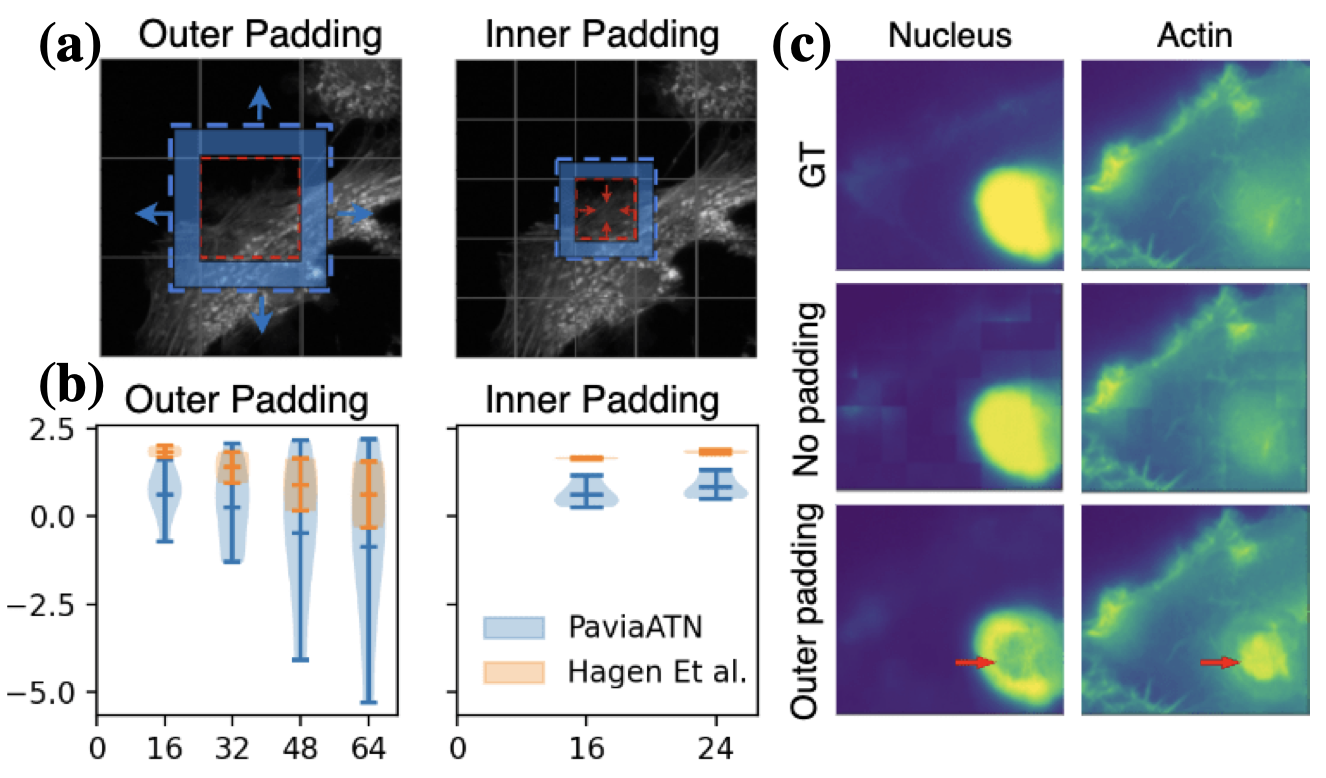

In [30]:
from microsplit_reproducibility.notebook_utils.HT_H23B import get_unnormalized_predictions, get_target, get_input

# Here we use a small helper function that returns the final results
# after performing Inner Padding, as mentioned above.
# Note also that it also returns `stitched_stds`, which is the pixel-wise
# standard deviation (std) between the posterior samples we have averaged
# while computing the MMSE per patch during tiled predictions. These 
# values will become most useful at the end of this notebook and in even 
# more so in `03_calibration.ipynb` for calibration and error estimations.
stitched_predictions, norm_stitched_predictions, stitched_stds = get_unnormalized_predictions(
    model,
    test_dset,
    data_key="test_input.zip.unzip",
    mmse_count = experiment_params['mmse_count'],
    grid_size=32, 
    num_workers=4, 
    batch_size=32)

# load inputs and noisy targets (needed for plotting later on)
inp = get_input(test_dset)
tar = get_target(test_dset)

Predicting tiles: 100%|██████████| 283/283 [00:22<00:00, 12.53it/s]


## Overview: visualize full <nobr>Micro$\mathbb{S}$plit</nobr> predictions...

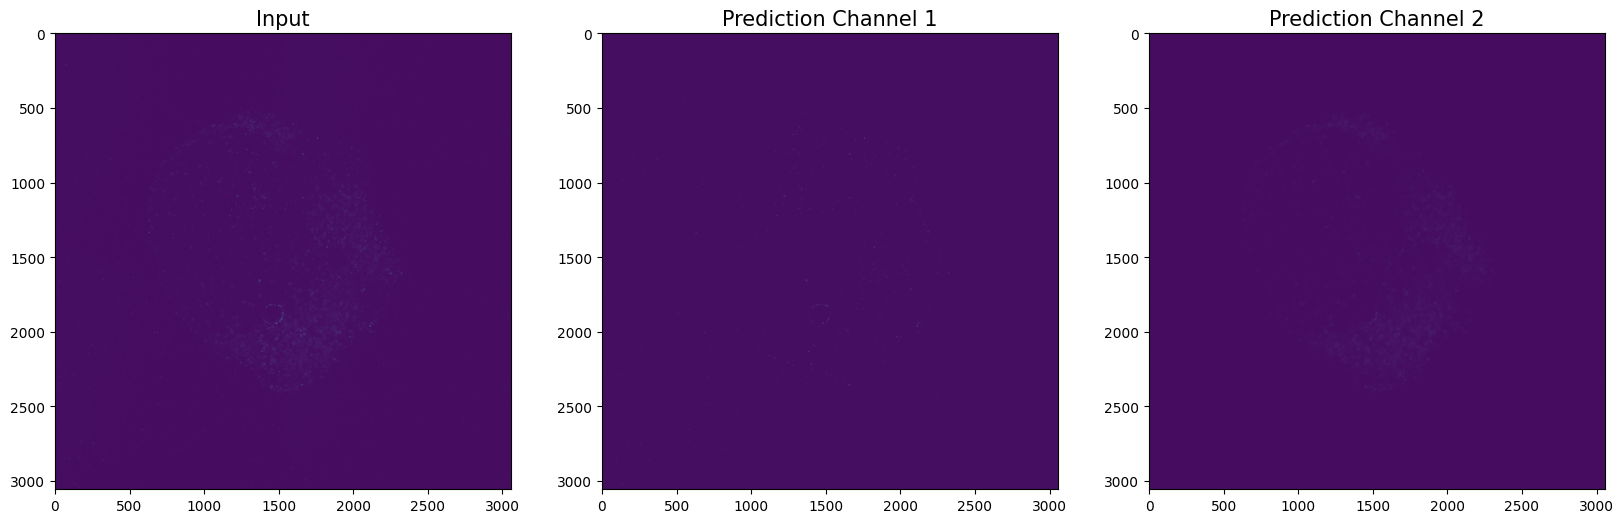

In [31]:
from microsplit_reproducibility.notebook_utils.HT_H23B import full_frame_evaluation

full_frame_evaluation(inp[0], stitched_predictions[0])

## Detailed view on some (foreground) locations...
Below, we show few random foreground locations and the corresponding <nobr>Micro$\mathbb{S}$plit</nobr> predictions.

You can execute the cell multiple times and different randomly chosen locations will be plotted.

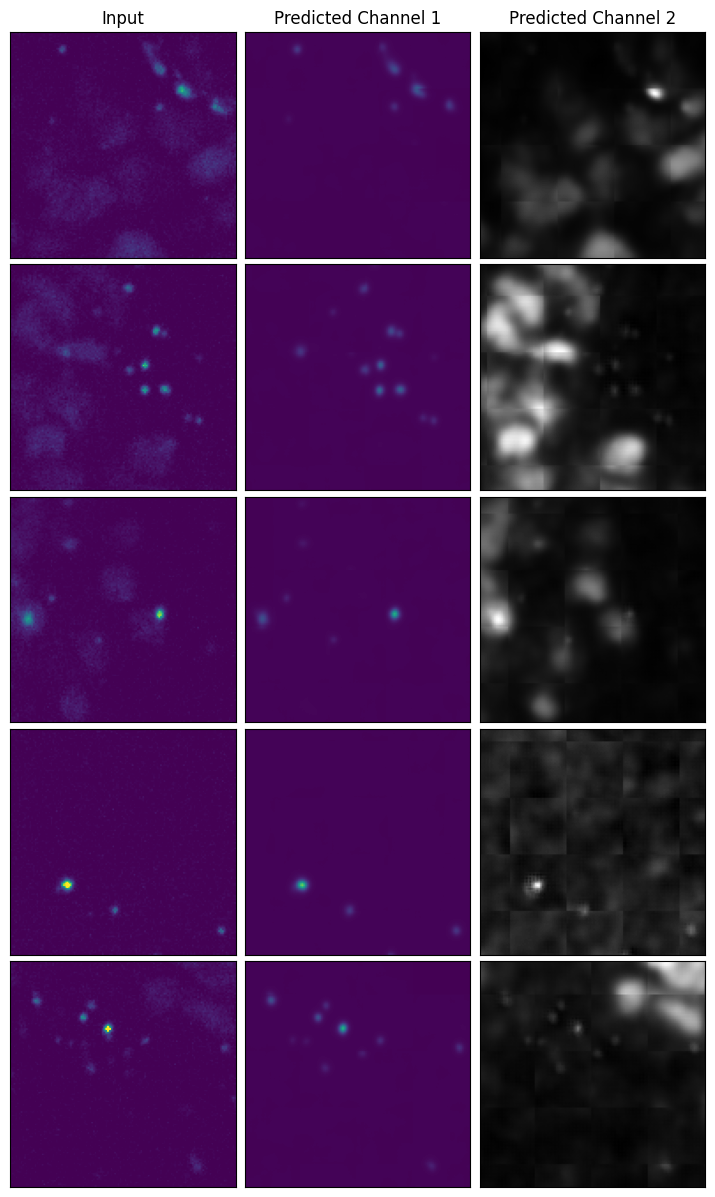

In [39]:
import numpy as np
from microsplit_reproducibility.utils.utils import clean_ax
from microsplit_reproducibility.notebook_utils.HT_H23B import pick_random_patches_with_content
import matplotlib.pyplot as plt

sample_idx = 0
img_sz = 128
rand_locations = pick_random_patches_with_content(tar[sample_idx], 128)
h_start = rand_locations[2,0] #np.random.randint(stitched_predictions.shape[1] - img_sz)
w_start = rand_locations[2,1] #np.random.randint(stitched_predictions.shape[2] - img_sz)

ncols = 3
nrows = min(len(rand_locations), 5)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))

for i, (h_start, w_start) in enumerate(rand_locations[:nrows]):
    vmin = stitched_predictions[sample_idx][0, 0, ...].min()
    vmax = stitched_predictions[sample_idx][0, 0, ...].max()
    ax[i,0].imshow(inp[sample_idx][0][h_start:h_start+img_sz, w_start:w_start+img_sz], vmin=vmin, vmax=vmax)
    ax[i,1].imshow(stitched_predictions[sample_idx][0, 0, h_start:h_start+img_sz, w_start:w_start+img_sz], vmin=vmin, vmax=vmax)
    ax[i,2].imshow(stitched_predictions[sample_idx][0, 1, h_start:h_start+img_sz, w_start:w_start+img_sz], cmap='gray')

for i in range(2):
    ax[0,0].set_title('Input')
    ax[0,1].set_title('Predicted Channel 1')
    ax[0,2].set_title('Predicted Channel 2')

# reduce the spacing between the subplots
plt.subplots_adjust(wspace=0.03, hspace=0.03)
clean_ax(ax)

## Manual inspection of the predictions
<div class="alert alert-block alert-info">
<b> Task:</b> Set <i>y_start</i>, <i>x_start</i>, and <i>crop_size</i> to inspect the predictions at a  location of your choice.
</div>

Here the crop you selected:


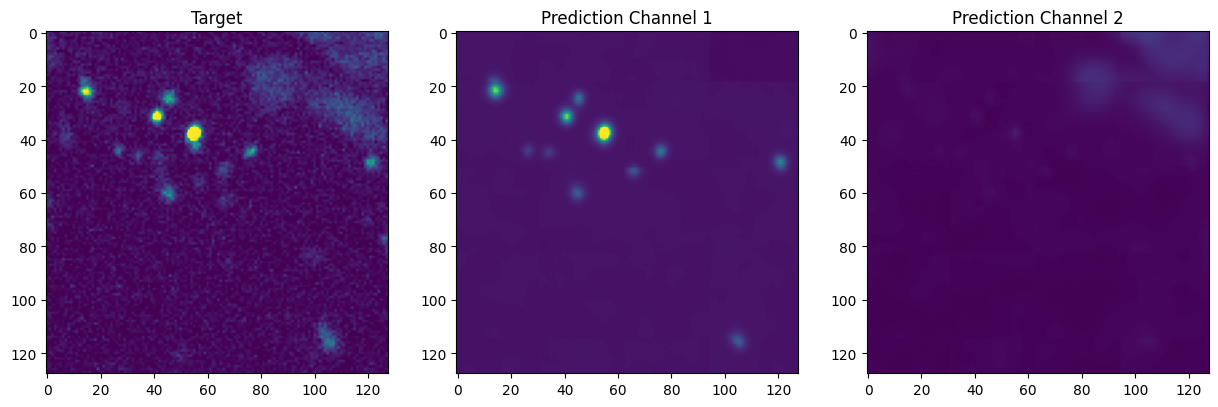

In [47]:
y_start = 400  #np.random.randint(stitched_predictions.shape[1] - crop_size)
x_start = 50 #np.random.randint(stitched_predictions.shape[2] - crop_size)
sample_idx = 0
channel_idx = 1
crop_size = 512

ncols = 3
nrows = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
vmin = stitched_predictions[sample_idx][0, channel_idx, ...].min()
vmax = stitched_predictions[sample_idx][0, channel_idx, ...].max()
ax[0].imshow(inp[sample_idx][0][h_start:h_start+img_sz, w_start:w_start+img_sz], vmin=vmin, vmax=vmax)
ax[1].imshow(stitched_predictions[sample_idx][0, 0, h_start:h_start+img_sz, w_start:w_start+img_sz], vmin=vmin, vmax=vmax)
ax[2].imshow(stitched_predictions[sample_idx][0, 1, h_start:h_start+img_sz, w_start:w_start+img_sz], vmin=vmin, vmax=vmax)

ax[0].set_title("Target")
ax[1].set_title("Prediction Channel 1")
ax[2].set_title("Prediction Channel 2")

print('Here the crop you selected:')